<a href="https://colab.research.google.com/github/probml/pyprobml/blob/master/notebooks/linreg_divorce_numpyro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Robust linear regression 

We illustrate  linear using the "waffle divorce" example in sec 5.1  of [Statistical Rethinking ed 2](https://xcelab.net/rm/statistical-rethinking/). 
The numpyro code is from [Du Phan's site](https://fehiepsi.github.io/rethinking-numpyro/05-the-many-variables-and-the-spurious-waffles.html)
  



In [1]:
!pip install -q numpyro@git+https://github.com/pyro-ppl/numpyro
!pip install -q arviz

     |████████████████████████████████| 1.6MB 15.0MB/s 
     |████████████████████████████████| 808kB 35.4MB/s 
     |████████████████████████████████| 4.7MB 36.1MB/s 
     |████████████████████████████████| 317kB 36.7MB/s 


In [24]:
import numpy as np
np.set_printoptions(precision=3)
import matplotlib.pyplot as plt
import math
import os
import warnings
import pandas as pd

import jax
print("jax version {}".format(jax.__version__))
print("jax backend {}".format(jax.lib.xla_bridge.get_backend().platform))

import jax.numpy as jnp
from jax import random, vmap

rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

import numpyro
import numpyro.distributions as dist
from numpyro.distributions import constraints
from numpyro.distributions.transforms import AffineTransform
from numpyro.diagnostics import hpdi, print_summary
from numpyro.infer import Predictive, log_likelihood
from numpyro.infer import MCMC, NUTS
from numpyro.infer import SVI, Trace_ELBO, init_to_value
from numpyro.infer.autoguide import AutoLaplaceApproximation
import numpyro.optim as optim


import arviz as az

jax version 0.2.12
jax backend cpu


# Data

The data records the divorce rate $D$, marriage rate $M$, and average age $A$ that people get married at for 50 US states.

In [4]:
# load data and copy
url = 'https://raw.githubusercontent.com/fehiepsi/rethinking-numpyro/master/data/WaffleDivorce.csv'
WaffleDivorce = pd.read_csv(url, sep=";")
d = WaffleDivorce

# standardize variables
d["A"] = d.MedianAgeMarriage.pipe(lambda x: (x - x.mean()) / x.std())
d["D"] = d.Divorce.pipe(lambda x: (x - x.mean()) / x.std())
d["M"] = d.Marriage.pipe(lambda x: (x - x.mean()) / x.std())

# Model (Gaussian likelihood)

We predict divorce rate D given marriage rate M and age A.

In [9]:
def model(M, A, D=None):
    a = numpyro.sample("a", dist.Normal(0, 0.2))
    bM = numpyro.sample("bM", dist.Normal(0, 0.5))
    bA = numpyro.sample("bA", dist.Normal(0, 0.5))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = numpyro.deterministic("mu", a + bM * M + bA * A)
    numpyro.sample("D", dist.Normal(mu, sigma), obs=D)


m5_3 = AutoLaplaceApproximation(model)
svi = SVI(model, m5_3, optim.Adam(1), Trace_ELBO(), M=d.M.values, A=d.A.values, D=d.D.values)
p5_3, losses = svi.run(random.PRNGKey(0), 1000)
post = m5_3.sample_posterior(random.PRNGKey(1), p5_3, (1000,))


100%|██████████| 1000/1000 [00:01<00:00, 718.29it/s, init loss: 3201.7393, avg. loss [951-1000]: 60.7879]


In [12]:
param_names = {'a', 'bA', 'bM', 'sigma'}
for p in param_names:
  print(f'posterior for {p}')
  print_summary(post[p], 0.95, False)
          


posterior for bM

                mean       std    median      2.5%     97.5%     n_eff     r_hat
   Param:0     -0.06      0.16     -0.06     -0.38      0.24    984.99      1.00

posterior for bA

                mean       std    median      2.5%     97.5%     n_eff     r_hat
   Param:0     -0.61      0.16     -0.61     -0.90     -0.30    822.38      1.00

posterior for sigma

                mean       std    median      2.5%     97.5%     n_eff     r_hat
   Param:0      0.80      0.08      0.79      0.65      0.94    971.25      1.00

posterior for a

                mean       std    median      2.5%     97.5%     n_eff     r_hat
   Param:0     -0.00      0.10     -0.01     -0.19      0.17   1049.96      1.00



# Posterior predicted vs actual

In [46]:
# call predictive without specifying new data
# so it uses original data
post = m5_3.sample_posterior(random.PRNGKey(1), p5_3, (int(1e4),))
post_pred = Predictive(m5_3.model, post)(random.PRNGKey(2), M=d.M.values, A=d.A.values)
mu = post_pred["mu"]

# summarize samples across cases
mu_mean = jnp.mean(mu, 0)
mu_PI = jnp.percentile(mu, q=(5.5, 94.5), axis=0)



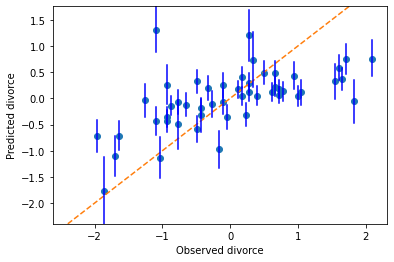

In [47]:
ax = plt.subplot(
    ylim=(float(mu_PI.min()), float(mu_PI.max())),
    xlabel="Observed divorce",
    ylabel="Predicted divorce"
)
plt.plot(d.D, mu_mean, "o")
x = jnp.linspace(mu_PI.min(), mu_PI.max(), 101)
plt.plot(x, x, "--")
for i in range(d.shape[0]):
    plt.plot([d.D[i]] * 2, mu_PI[:, i], "b")
fig = plt.gcf()

<Figure size 432x288 with 0 Axes>

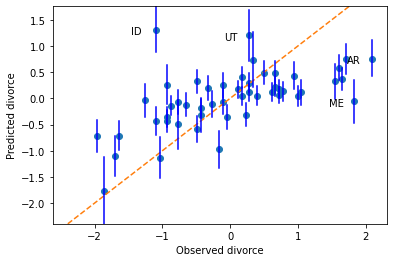

In [48]:
for i in range(d.shape[0]):
    if d.Loc[i] in ["ID", "UT", "AR", "ME"]:
        ax.annotate(
            d.Loc[i], (d.D[i], mu_mean[i]), xytext=(-25, -5), textcoords="offset pixels"
        )
plt.tight_layout()
plt.savefig('linreg_divorce_postpred.pdf')
plt.show()
fig

# Per-point LOO scores

We compute the predicted probability of each point given the others, following
sec 7.5.2   of [Statistical Rethinking ed 2](https://xcelab.net/rm/statistical-rethinking/). 
The numpyro code is from [Du Phan's site](https://fehiepsi.github.io/rethinking-numpyro/07-ulysses-compass.html)
  


In [49]:
#post = m5_3.sample_posterior(random.PRNGKey(24071847), p5_3, (1000,))
logprob = log_likelihood(m5_3.model, post, A=d.A.values, M=d.M.values, D=d.D.values)[
    "D"
]
az5_3 = az.from_dict(
    posterior={k: v[None, ...] for k, v in post.items()},
    log_likelihood={"D": logprob[None, ...]},
)

/usr/local/lib/python3.7/dist-packages/arviz/stats/stats.py:656: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "
/usr/local/lib/python3.7/dist-packages/arviz/stats/stats.py:1407: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


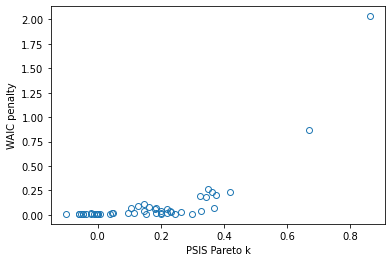

In [61]:
PSIS_m5_3 = az.loo(az5_3, pointwise=True, scale="deviance")
WAIC_m5_3 = az.waic(az5_3, pointwise=True, scale="deviance")
penalty = az5_3.log_likelihood.stack(sample=("chain", "draw")).var(dim="sample")

fig, ax = plt.subplots()
ax.plot(PSIS_m5_3.pareto_k.values, penalty.D.values, "o", mfc="none")
ax.set_xlabel("PSIS Pareto k")
ax.set_ylabel("WAIC penalty")

plt.savefig('linreg_divorce_waic_vs_pareto.pdf')
plt.show()
plt.show()

ID 0.8625359073761971 2.032347
ME 0.669250330617351 0.86887264
ND 0.4184033659196669 0.22986734


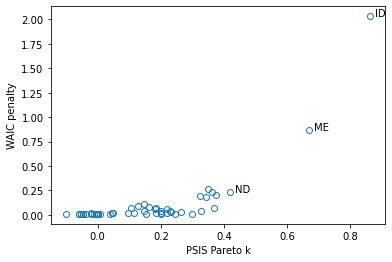

In [62]:
pareto =  PSIS_m5_3.pareto_k.values
waic = penalty.D.values
ndx = np.where(pareto > 0.4)[0]
for i in ndx:
  print(d.Loc[i], pareto[i], waic[i])


for i in ndx:
    ax.annotate(d.Loc[i], (pareto[i], waic[i]), xytext=(5, 0), textcoords="offset pixels")
fig

# Student likelihood

In [55]:
def model(M, A, D=None):
    a = numpyro.sample("a", dist.Normal(0, 0.2))
    bM = numpyro.sample("bM", dist.Normal(0, 0.5))
    bA = numpyro.sample("bA", dist.Normal(0, 0.5))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    #mu = a + bM * M + bA * A
    mu = numpyro.deterministic("mu", a + bM * M + bA * A)
    numpyro.sample("D", dist.StudentT(2, mu, sigma), obs=D)


m5_3t = AutoLaplaceApproximation(model)
svi = SVI(
    model, m5_3t, optim.Adam(0.3), Trace_ELBO(), M=d.M.values, A=d.A.values, D=d.D.values
)
p5_3t, losses = svi.run(random.PRNGKey(0), 1000)

100%|██████████| 1000/1000 [00:01<00:00, 677.59it/s, init loss: 194.5655, avg. loss [951-1000]: 63.3271]


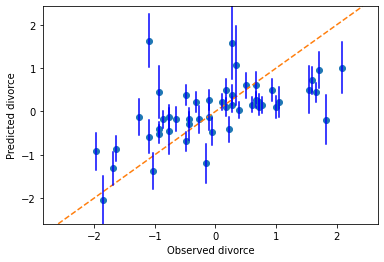

In [56]:
# call predictive without specifying new data
# so it uses original data
post_t = m5_3t.sample_posterior(random.PRNGKey(1), p5_3t, (int(1e4),))
post_pred_t = Predictive(m5_3t.model, post_t)(random.PRNGKey(2), M=d.M.values, A=d.A.values)
mu = post_pred_t["mu"]

# summarize samples across cases
mu_mean = jnp.mean(mu, 0)
mu_PI = jnp.percentile(mu, q=(5.5, 94.5), axis=0)


ax = plt.subplot(
    ylim=(float(mu_PI.min()), float(mu_PI.max())),
    xlabel="Observed divorce",
    ylabel="Predicted divorce"
)
plt.plot(d.D, mu_mean, "o")
x = jnp.linspace(mu_PI.min(), mu_PI.max(), 101)
plt.plot(x, x, "--")
for i in range(d.shape[0]):
    plt.plot([d.D[i]] * 2, mu_PI[:, i], "b")
fig = plt.gcf()